<a href="https://colab.research.google.com/github/TanmoyGG/CVPR/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import os
from PIL import Image
from pathlib import Path
import pillow_heif
import numpy as np

try:
    import rawpy
    HAS_RAWPY = True
    print("✓ rawpy successfully imported")
except ImportError as e:
    HAS_RAWPY = False
    print(f"✗ rawpy import failed: {e}")
    print("Installing rawpy...")
    import subprocess
    subprocess.check_call([__import__('sys').executable, "-m", "pip", "install", "rawpy"])
    import rawpy
    HAS_RAWPY = True
    print("✓ rawpy installed successfully")

try:
    import imageio
    HAS_IMAGEIO = True
    print("✓ imageio successfully imported")
except ImportError as e:
    HAS_IMAGEIO = False
    print(f"✗ imageio import failed: {e}")
    print("Installing imageio...")
    import subprocess
    subprocess.check_call([__import__('sys').executable, "-m", "pip", "install", "imageio", "imageio-ffmpeg"])
    import imageio
    HAS_IMAGEIO = True
    print("✓ imageio installed successfully")

try:
    import cv2
    HAS_CV2 = True
    print("✓ opencv (cv2) successfully imported")
except ImportError as e:
    HAS_CV2 = False
    print(f"✗ opencv import failed: {e}")
    print("Installing opencv...")
    import subprocess
    subprocess.check_call([__import__('sys').executable, "-m", "pip", "install", "opencv-python"])
    import cv2
    HAS_CV2 = True
    print("✓ opencv installed successfully")

# Register HEIF opener with PIL
pillow_heif.register_heif_opener()

✓ rawpy successfully imported
✓ imageio successfully imported
✓ opencv (cv2) successfully imported


In [ ]:
# Test DNG processing (optional - for debugging)
test_dng_folder = 'dataset/22-46887-1'
if os.path.exists(test_dng_folder):
    dng_files = [f for f in os.listdir(test_dng_folder) if f.lower().endswith('.dng')]
    if dng_files:
        print(f"\nFound {len(dng_files)} DNG files: {dng_files}")
        print("Testing DNG conversion on first file...")
        test_path = os.path.join(test_dng_folder, dng_files[0])

        # Try rawpy first
        if HAS_RAWPY:
            try:
                with rawpy.imread(test_path) as raw:
                    rgb_array = raw.postprocess()
                    print(f"✓ rawpy conversion successful: {rgb_array.shape}")
            except Exception as e:
                print(f"✗ rawpy failed: {e}")

                # Try imageio
                if HAS_IMAGEIO:
                    print("Trying imageio...")
                    try:
                        img_array = imageio.imread(test_path)
                        print(f"✓ imageio conversion successful: {img_array.shape}")
                    except Exception as e2:
                        print(f"✗ imageio also failed: {e2}")

                        # Try OpenCV
                        if HAS_CV2:
                            print("Trying opencv (cv2)...")
                            try:
                                img_cv = cv2.imread(test_path, cv2.IMREAD_UNCHANGED)
                                if img_cv is not None:
                                    print(f"✓ OpenCV conversion successful: {img_cv.shape}")
                                else:
                                    print("✗ OpenCV returned None for DNG")
                            except Exception as e3:
                                print(f"✗ OpenCV also failed: {e3}")
        else:
            print("rawpy not available, trying imageio...")
            if HAS_IMAGEIO:
                try:
                    img_array = imageio.imread(test_path)
                    print(f"✓ imageio conversion successful: {img_array.shape}")
                except Exception as e:
                    print(f"✗ imageio failed: {e}")
                    if HAS_CV2:
                        print("Trying opencv (cv2)...")
                        try:
                            img_cv = cv2.imread(test_path, cv2.IMREAD_UNCHANGED)
                            if img_cv is not None:
                                print(f"✓ OpenCV conversion successful: {img_cv.shape}")
                            else:
                                print("✗ OpenCV returned None for DNG")
                        except Exception as e3:
                            print(f"✗ OpenCV also failed: {e3}")


Found 3 DNG files: ['IMG_1244(1).DNG', 'IMG_1244.DNG', 'IMG_1247.DNG']
Testing DNG conversion on first file...
✗ rawpy failed: b'Unsupported file format or not RAW file'
Trying imageio...
✓ imageio conversion successful: (3088, 2316, 3)


C:\Users\tanmo\AppData\Local\Temp\ipykernel_23852\3222239668.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_array = imageio.imread(test_path)


In [ ]:
# Define paths
source_folder = 'dataset'
output_folder = 'dataset_processed'
target_size = (524, 524)

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

print(f"Source folder: {source_folder}")
print(f"Output folder: {output_folder}")
print(f"Target size: {target_size}")

Source folder: dataset
Output folder: dataset_processed
Target size: (524, 524)


In [ ]:
# Get all unique ID folders
unique_id_folders = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f))]
print(f"Found {len(unique_id_folders)} unique ID folders")
print(f"First 5 folders: {unique_id_folders[:5]}")

Found 66 unique ID folders
First 5 folders: ['21-45902-3', '22-46138-1', '22-46139-1', '22-46141-1', '22-46275-1']


In [ ]:
# Function to process a single image
def process_image(input_path, output_path, target_size=(524, 524)):
    """
    Process an image: crop to square and resize to target size without flipping
    Supports: JPG, JPEG, PNG, HEIC, DNG

    Args:
        input_path: Path to input image
        output_path: Path to save processed image
        target_size: Tuple of (width, height) for resizing
    """
    try:
        # Check if file is DNG
        file_ext = os.path.splitext(input_path)[1].lower()

        if file_ext == '.dng':
            # Handle DNG files with multiple fallback methods
            img = None

            # Try rawpy first
            if HAS_RAWPY:
                try:
                    with rawpy.imread(input_path) as raw:
                        rgb_array = raw.postprocess()
                        img = Image.fromarray(rgb_array)
                except:
                    pass

            # Fallback to imageio
            if img is None and HAS_IMAGEIO:
                try:
                    img_array = imageio.imread(input_path)
                    if len(img_array.shape) == 3 and img_array.shape[2] >= 3:
                        img = Image.fromarray(img_array[:, :, :3].astype('uint8'))
                    else:
                        img = Image.fromarray(img_array.astype('uint8'))
                except:
                    pass

            # Fallback to OpenCV
            if img is None and HAS_CV2:
                try:
                    img_cv = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
                    if img_cv is not None:
                        # OpenCV reads in BGR, convert to RGB
                        if len(img_cv.shape) == 3 and img_cv.shape[2] >= 3:
                            img_rgb = cv2.cvtColor(img_cv[:, :, :3], cv2.COLOR_BGR2RGB)
                            img = Image.fromarray(img_rgb.astype('uint8'))
                        else:
                            img = Image.fromarray(img_cv.astype('uint8'))
                except:
                    pass

            if img is None:
                print(f"No suitable library available to process DNG: {input_path}")
                return False
        else:
            # Open other image formats
            img = Image.open(input_path)

        # Handle EXIF orientation to prevent flipping (skip for DNG as it's already processed)
        if file_ext != '.dng':
            try:
                from PIL.ExifTags import TAGS
                exif_data = img._getexif()
                if exif_data:
                    for tag_id, value in exif_data.items():
                        tag = TAGS.get(tag_id, tag_id)
                        if tag == 'Orientation':
                            # Orientation tag values:
                            # 1 = normal, 2 = flipped horizontally, 3 = rotated 180,
                            # 4 = flipped vertically, 5 = transposed, 6 = rotated 90 CW,
                            # 7 = transposed, 8 = rotated 90 CCW
                            if value == 2:
                                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                            elif value == 3:
                                img = img.rotate(180, expand=False)
                            elif value == 4:
                                img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
                            elif value == 5:
                                img = img.transpose(Image.Transpose.TRANSPOSE)
                            elif value == 6:
                                img = img.rotate(270, expand=False)
                            elif value == 7:
                                img = img.transpose(Image.Transpose.TRANSVERSE)
                            elif value == 8:
                                img = img.rotate(90, expand=False)
            except:
                # If EXIF data is not available, continue without modification
                pass

        # Convert to RGB if necessary (for PNG with transparency or HEIC)
        if img.mode in ('RGBA', 'LA', 'P'):
            # Create a white background
            background = Image.new('RGB', img.size, (255, 255, 255))
            if img.mode == 'P':
                img = img.convert('RGBA')
            background.paste(img, mask=img.split()[-1] if img.mode in ('RGBA', 'LA') else None)
            img = background
        elif img.mode != 'RGB':
            img = img.convert('RGB')

        # Crop to square from center
        width, height = img.size
        min_dimension = min(width, height)

        # Calculate crop coordinates to center the crop
        left = (width - min_dimension) // 2
        top = (height - min_dimension) // 2
        right = left + min_dimension
        bottom = top + min_dimension

        # Crop to square
        img_cropped = img.crop((left, top, right, bottom))

        # Resize image to target size
        img_resized = img_cropped.resize(target_size, Image.Resampling.LANCZOS)

        # Save as JPG without EXIF data to prevent any orientation issues
        img_resized.save(output_path, 'JPEG', quality=95, exif=b'')

        return True
    except Exception as e:
        print(f"Error processing {input_path}: {str(e)}")
        return False

In [ ]:
# Process all images
total_images = 0
processed_images = 0
failed_images = 0

# Supported image extensions
image_extensions = {'.jpg', '.jpeg', '.png', '.heic', '.dng', '.JPG', '.JPEG', '.PNG', '.HEIC', '.DNG'}

for folder_name in unique_id_folders:
    # Create corresponding output folder
    input_folder_path = os.path.join(source_folder, folder_name)
    output_folder_path = os.path.join(output_folder, folder_name)
    os.makedirs(output_folder_path, exist_ok=True)

    # Get all image files in the folder
    image_files = [f for f in os.listdir(input_folder_path)
                   if os.path.splitext(f)[1] in image_extensions]

    print(f"\nProcessing folder: {folder_name} ({len(image_files)} images)")

    # Sort image files for consistent ordering
    image_files.sort()

    # Process each image with sequential numbering
    for idx, image_file in enumerate(image_files, start=1):
        total_images += 1

        # Input and output paths
        input_path = os.path.join(input_folder_path, image_file)

        # Rename as sequential: 1.jpg, 2.jpg, 3.jpg, etc.
        output_filename = f'{idx}.jpg'
        output_path = os.path.join(output_folder_path, output_filename)

        # Process the image
        if process_image(input_path, output_path, target_size):
            processed_images += 1
            print(f"  ✓ Processed: {image_file} -> {output_filename}")
        else:
            failed_images += 1

print("\n" + "="*60)
print("Processing Complete!")
print(f"Total images: {total_images}")
print(f"Successfully processed: {processed_images}")
print(f"Failed: {failed_images}")
print("="*60)


Processing folder: 21-45902-3 (20 images)
  ✓ Processed: IMG_3392.jpeg -> 1.jpg
  ✓ Processed: IMG_3393.jpeg -> 2.jpg
  ✓ Processed: IMG_3394.jpeg -> 3.jpg
  ✓ Processed: IMG_3395.jpeg -> 4.jpg
  ✓ Processed: IMG_3396.jpeg -> 5.jpg
  ✓ Processed: IMG_3398.jpeg -> 6.jpg
  ✓ Processed: IMG_3630.jpeg -> 7.jpg
  ✓ Processed: IMG_3632.jpeg -> 8.jpg
  ✓ Processed: IMG_3633.jpeg -> 9.jpg
  ✓ Processed: IMG_3635.jpeg -> 10.jpg
  ✓ Processed: IMG_3636.jpeg -> 11.jpg
  ✓ Processed: IMG_3637.jpeg -> 12.jpg
  ✓ Processed: IMG_3638.jpeg -> 13.jpg
  ✓ Processed: IMG_3639.jpeg -> 14.jpg
  ✓ Processed: IMG_3640.jpeg -> 15.jpg
  ✓ Processed: IMG_3641.jpeg -> 16.jpg
  ✓ Processed: IMG_3642.jpeg -> 17.jpg
  ✓ Processed: IMG_3643.jpeg -> 18.jpg
  ✓ Processed: IMG_3644.jpeg -> 19.jpg
  ✓ Processed: IMG_3647.jpeg -> 20.jpg

Processing folder: 22-46138-1 (20 images)
  ✓ Processed: IMG_2908.HEIC -> 1.jpg
  ✓ Processed: IMG_2909.HEIC -> 2.jpg
  ✓ Processed: IMG_2910.HEIC -> 3.jpg
  ✓ Processed: IMG_2911.HEIC 

C:\Users\tanmo\AppData\Local\Temp\ipykernel_23852\3678116088.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_array = imageio.imread(input_path)


  ✓ Processed: IMG_1244(1).DNG -> 6.jpg
  ✓ Processed: IMG_1244.DNG -> 7.jpg
  ✓ Processed: IMG_1247.DNG -> 8.jpg
  ✓ Processed: IMG_1251(1).JPG -> 9.jpg
  ✓ Processed: IMG_1251.JPG -> 10.jpg
  ✓ Processed: IMG_1252.JPG -> 11.jpg
  ✓ Processed: IMG_1254.JPG -> 12.jpg
  ✓ Processed: IMG_1256.JPG -> 13.jpg
  ✓ Processed: IMG_1258.JPG -> 14.jpg
  ✓ Processed: IMG_1259(1).JPG -> 15.jpg
  ✓ Processed: IMG_1259.JPG -> 16.jpg
  ✓ Processed: IMG_1260.JPG -> 17.jpg
  ✓ Processed: IMG_1261.JPG -> 18.jpg
  ✓ Processed: IMG_1262.JPG -> 19.jpg
  ✓ Processed: IMG_1272.JPG -> 20.jpg

Processing folder: 22-46945-1 (20 images)
  ✓ Processed: 1.png -> 1.jpg
  ✓ Processed: 10.png -> 2.jpg
  ✓ Processed: 11.png -> 3.jpg
  ✓ Processed: 12.png -> 4.jpg
  ✓ Processed: 13.png -> 5.jpg
  ✓ Processed: 14.png -> 6.jpg
  ✓ Processed: 15.png -> 7.jpg
  ✓ Processed: 16.png -> 8.jpg
  ✓ Processed: 17.png -> 9.jpg
  ✓ Processed: 18.png -> 10.jpg
  ✓ Processed: 19.png -> 11.jpg
  ✓ Processed: 2.png -> 12.jpg
  ✓ Proce

In [ ]:
# Verification: Check the processed dataset
print("\nVerification of processed dataset:")
print("="*60)

processed_folders = [f for f in os.listdir(output_folder) if os.path.isdir(os.path.join(output_folder, f))]
print(f"Total folders in dataset_processed: {len(processed_folders)}")

total_processed_images = 0
for folder_name in processed_folders:
    folder_path = os.path.join(output_folder, folder_name)
    images = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    total_processed_images += len(images)
    print(f"  {folder_name}: {len(images)} images")

print(f"\nTotal processed images: {total_processed_images}")


Verification of processed dataset:
Total folders in dataset_processed: 66
  21-45902-3: 20 images
  22-46138-1: 20 images
  22-46139-1: 20 images
  22-46141-1: 20 images
  22-46275-1: 20 images
  22-46293-1: 20 images
  22-46342-1: 20 images
  22-46473-1: 20 images
  22-46536-1: 20 images
  22-46590-1: 20 images
  22-46666-1: 20 images
  22-46679-1: 20 images
  22-46887-1: 20 images
  22-46945-1: 20 images
  22-46983-1: 20 images
  22-47180-1: 20 images
  22-47294-1: 20 images
  22-47402-2: 20 images
  22-47884-2: 20 images
  22-47892-2: 20 images
  22-47894-2: 20 images
  22-47898-2: 20 images
  22-47925-2: 20 images
  22-47968-2: 20 images
  22-48055-2: 20 images
  22-48064-2: 20 images
  22-48091-2: 20 images
  22-48133-2: 20 images
  22-48205-2: 20 images
  22-48434-3: 20 images
  22-48541-3: 20 images
  22-48569-3: 20 images
  22-48582-3: 20 images
  22-48833-3: 20 images
  22-49037-3: 19 images
  22-49068-3: 20 images
  22-49167-3: 20 images
  22-49196-3: 20 images
  22-49338-3:

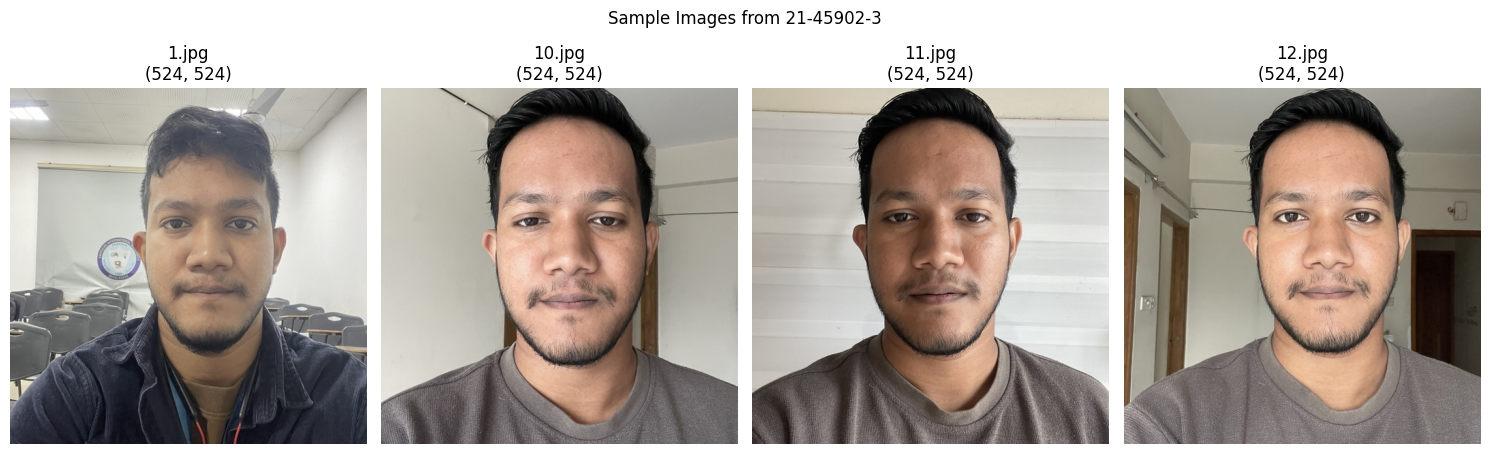

In [ ]:
# Display sample of processed images
import matplotlib.pyplot as plt

# Check if there are any processed folders
if not processed_folders or len(processed_folders) == 0:
    print("No processed folders found. Please run the processing cell first.")
else:
    # Get first folder and first few images
    sample_folder = processed_folders[0]
    sample_folder_path = os.path.join(output_folder, sample_folder)
    sample_images = [f for f in os.listdir(sample_folder_path) if f.endswith('.jpg')][:4]

    if len(sample_images) == 0:
        print(f"No JPG images found in {sample_folder}")
    else:
        fig, axes = plt.subplots(1, min(4, len(sample_images)), figsize=(15, 5))
        if len(sample_images) == 1:
            axes = [axes]

        for idx, img_name in enumerate(sample_images):
            img_path = os.path.join(sample_folder_path, img_name)
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"{img_name}\n{img.size}")
            axes[idx].axis('off')

        plt.suptitle(f"Sample Images from {sample_folder}")
        plt.tight_layout()
        plt.show()